# General Method

## Inputs

- Cost of an on-chain transaction $C > 0$
- Channel reset cost $D > 0$
- Discount factor $\alpha \in (0,1)$ 
- Payment amount probability density function $g:\mathbb{R} \to \mathbb{R}_+$
- Fine-tuning parameter $n \in \mathbb{N}$
- Second fine-tuning parameter $k \in \mathbb{N}_0$

## Outputs 

- Optimal channel deposits $l_{A,n}^{*}$ and $l_{B,n}^{*}$
- Optimal policy $f_{n,k}^{*}$

The process of transforming inputs into the desired outputs involves three key steps:

1. **Expected Transaction Cost Calculation**: Compute the optimal cost function $T_n^*( x \,|\, l_A, l_B)$ for $x \in \{ -l_A, -l_A + \tfrac{1}{2n}, \ldots, l_B-\tfrac{1}{2n}, l_B \}$ for any pair of channel deposits $l_A, l_B \in R_n := \{ \tfrac{k}{2n} : 0 \leq k \leq \tfrac{2n\alpha C}{1-\alpha} \textnormal{ and } k \in \mathbb{N}_0 \}$.

2. **Optimization of Channel Deposits**: Next, minimize the function  $(l_A, l_B) \mapsto l_A + l_B + T_n^*(0 \,|\, l_A, l_B) =: V_n(l_A, l_B)$ over  $R^2_n$ to determine the optimal channel deposits $ l_{A,n}^{*} $ and  $ l_{B,n}^{*} $.

3. **Deriving the Optimal Policy**: Finally, compute the optimal policy $ f_{n,k}^{*} $ from the cost function $T_n^*(\cdot \,|\, l_{A,n}^{*}, l_{B,n}^{*})$ using the optimized channel deposits.

## Step 1

This is based on Algorithm 1 from our paper "Chain or Channel? Payment Optimization with Heterogeneous Flow". First, define the function: 

$$I(x,y) :=  \mathbb{P}[x \leq \Delta \leq y] = \int_x^y g(z) dz, \quad x \leq y.$$

In all of our examples, $I$ has a closed-form expression, making it straightforward to implement in Python. However, if this were not the case, then you must numerically approximate $I$ instead. For example: 

In [154]:
import numpy as np

def I(x, y):
    # Compute the integral of g(z) from x to y
    result = np.trapz(g(np.linspace(x, y, 1000)), np.linspace(x, y, 1000))
    return result

The following code allows us to compute $T_n^*( x \,|\, l_A, l_B)$ for $x \in \{ -l_A, -l_A + \tfrac{1}{2n}, \ldots, l_B-\tfrac{1}{2n}, l_B \}$ for any pair of channel deposits $l_A, l_B \in R_n$. In other words, it finds the unique fixed point of the function $F$ from Algorithm 1.

In [8]:
import numpy as np
from scipy.optimize import root
from dataclasses import dataclass


# Define the PaymentParams class
@dataclass
class PaymentParams:
    l_A: float  # Alice's channel deposit
    l_B: float  # Bob's channel deposit
    C: float  # On-chain cost
    D: float  # Reset cost
    alpha: float  # Discount factor
    n: int  # Fine-tuning parameter
    I: callable  # Cumulative probability between two points


# Define the vector h from Algorithm 1 
def h_vector(params: PaymentParams):
    N = int(2 * params.n * (params.l_A + params.l_B))
    h = np.array([
        1 - params.I(-(i + 1) / (2 * params.n), params.l_A + params.l_B - (i - 1) / (2 * params.n))
        if i % 2 != 0 else
        1 - params.I(-i / (2 * params.n), params.l_A + params.l_B - i / (2 * params.n))
        for i in range(N + 1)
    ])
    return h


# Define the vector p from Algorithm 1
def p_vector(params: PaymentParams):
    M = int(4 * params.n * (params.l_A + params.l_B))
    p = np.zeros(M+1)
    for i in range(1, M + 1, 2):
        p[i] = params.I(-(params.l_A + params.l_B) + (i - 1) / (2 * params.n), -(params.l_A + params.l_B) + (i + 1) / (2 * params.n))
    return p


# Define the F function from Algorithm 1
def F(v, params: PaymentParams):
    N = int((params.l_A + params.l_B) * 2 * params.n)
    p = p_vector(params)
    h = h_vector(params)
    
    Fv = np.zeros(N+1)
    base_index = int(params.l_A * 2 * params.n)

    # Compute the vector F(v)
    for i in range(N+1):
        min_v = np.minimum(params.C + v[i], params.D + v[base_index])
        Fv[i] = params.alpha * (
            min(params.C + v[i], params.C + params.D + v[base_index]) * h[i] +
            np.sum(np.minimum(min_v, v[i + np.arange(-i, N - i + 1)]) * p[N + np.arange(-i, N - i + 1)])
        )
    
    return Fv


# The unique fixed point of F is the unique root of the function G(v)=F(v)-v
def G(v, params: PaymentParams):
    Fv = F(v, params)
    Gv = Fv - v
    return Gv


# Define the optimal transaction cost function
def T_n(params: PaymentParams):
    initial_guess = np.zeros(int((params.l_A + params.l_B) * 2 * params.n + 1))
    
    # Find the root of G using the root function from scipy.optimize
    Fixed_Point = root(G, initial_guess, args=(params), method='hybr')
    if Fixed_Point.success:
        return Fixed_Point.x
    else:
        raise ValueError(f"Root-finding did not converge: {Fixed_Point.message}")


# Example usage of the code 

# Exponentially distributed payments with mean 1 (unidirectional)
def I(x,y):
    if x >= 0:
        return np.exp(-x) - np.exp(-y)
    elif y <= 0:
        return 0
    else:
        return 1 - np.exp(-y)
    
params = PaymentParams(
    l_A = 0, 
    l_B = 20, 
    C = 1.0, 
    D = 2.0, 
    alpha = 1 / (1 + 0.02), 
    n = 10, 
    I = I  # The function I defined above
)

# Find the optimal cost vector
optimal_cost_vector = T_n(params)
print("Optimal Cost Vector:", optimal_cost_vector) # ith component is T_n^*(-l_A + i / (2*n) | l_A, l_B)

Optimal Cost Vector: [4.68252341 4.68711289 4.69170687 ... 7.43858905 7.43858905 7.5318857 ]


## Step 2 

We begin Step 2 by using the function $T_n$ from Step 1 to define the value function $V_n$:

In [10]:
def V_n(l_A, l_B, params: PaymentParams):
    params.l_A = l_A  # Set the current l_A
    params.l_B = l_B  # Set the current l_B
    optimal_cost_vector = T_n(params)  # Compute the optimal cost vector
    origin = int(params.l_A * 2 * params.n)  # Compute the index corresponding to the origin of the payment channel
    return params.l_A + params.l_B + optimal_cost_vector[origin]  # Compute V_n(l_A, l_B)

In order to minimize $V_n$ over $R_n^2$, we apply a multi-level search strategy, which makes use of the properties that $V$ is continuous on $\mathbb{R}_+^2$ and $V_n(l_A, l_B) \geq l_A + l_B$. The idea is as follows:

1. **Coarse Search**: Perform a coarse search over a reduced grid of $R_n^2$. For example, if $R_n = \{ 0, 1, 2, \ldots, 99999, 100000 \}$ and we calculated $V_n(100, 100) = 300$, we first search over the set $\{ (l_A, l_B) \in \{0, 10, 20, \ldots, 290, 300\}^2 : l_A + l_B \leq 300 \}$. This gives us a rough estimate of the region around the minimum.
2. **Refined Search**: After identifying the approximate location of the minimum from the coarse search (say, around $l_A=60$, $l_B=140$), we perform a finer search around this region with smaller increments (e.g. $(l_A, l_B) \in \{ 55, 56, \ldots, 64, 65 \} \times \{ 135, 136, \ldots, 144, 145 \}$).

By accounting for whether payments are unidirectional or symmetric, we can further optimize the search by restricting the values of $l_A$ and $l_B$:

- **Unidirectional**: We can set $l_A = 0$, which means we only need to search over $l_B$.
- **Symmetric**: We can enforce $l_A = l_B$, which reduces the search space to just one variable, $l_A$.

Putting all of this together gives:

In [13]:
def search_over_grid(params: PaymentParams, step_size, l_max, unidirectional=False, symmetric=False):
    """
    Function to perform a search for the minimum of V_n over a reduced grid determined by step size and l_max.

    Parameters:
    step_size: divisible by 1/(2 * params.n).
    l_max: an element of R_n that is divisible by step_size.
    unidirectional: If true, we can set l_A = 0 and only search over l_B.
    symmetric: If true, we can enforce l_A = l_B, which reduces the search space to just one variable. 
    
    Returns:
    optimal l_A, optimal l_B and minimum value over reduced grid.
    """
    
    min_value = float('inf')
    optimal_l_A, optimal_l_B = None, None

    if unidirectional:
        # If unidirectional, set l_A = 0 and only search over l_B
        valid_l_B_values = np.arange(0, l_max + step_size, step_size)
        l_A = 0
        for l_B in valid_l_B_values:
            current_value = V_n(l_A, l_B, params)
            if current_value < min_value:
                min_value = current_value
                optimal_l_A, optimal_l_B = l_A, l_B
    
    elif symmetric:
        # If symmetric, enforce l_A = l_B, so search over one variable
        valid_l_A_values = np.arange(0, l_max / 2 + step_size, step_size)
        for l_A in valid_l_A_values:
            l_B = l_A  # Since l_A = l_B in symmetric case
            current_value = V_n(l_A, l_B, params)
            if current_value < min_value:
                min_value = current_value
                optimal_l_A, optimal_l_B = l_A, l_B
    
    else:
        # General case: search over both l_A and l_B with l_A + l_B <= l_max
        valid_l_A_values = np.arange(0, l_max + step_size, step_size)
        for l_A in valid_l_A_values:
            valid_l_B_values = np.arange(0, l_max - l_A + step_size, step_size)
            for l_B in valid_l_B_values:
                current_value = V_n(l_A, l_B, params)
                if current_value < min_value:
                    min_value = current_value
                    optimal_l_A, optimal_l_B = l_A, l_B

    return optimal_l_A, optimal_l_B, min_value


def multi_level_search(params: PaymentParams, coarse_step, l_max, fine_step, search_radius, unidirectional=False, symmetric=False):
    """
    Function to perform a multi-level search for the minimum of V_n over entire grid.

    Parameters:
    coarse_step: divisible by 1/(2 * params.n).
    l_max: an element of R_n that is divisible by coarse_step.
    fine_step: divisible by 1/(2 * params.n) and smaller than step_size.
    search_radius: divisible by 1/(2 * params.n).
    unidirectional: If true, we can set l_A = 0 and only search over l_B.
    symmetric: If true, we can enforce l_A = l_B, which reduces the search space to just one variable l_A.
    
    Returns:
    optimal l_A, optimal l_B and minimum value over entire grid.
    """
    
    print(f"Starting coarse search with step size: {coarse_step}, l_max: {l_max}")
    
    # Step 1: Coarse search over a reduced grid within l_A + l_B <= l_max
    optimal_l_A_coarse, optimal_l_B_coarse, min_V_coarse = search_over_grid(
        params, coarse_step, l_max, unidirectional, symmetric
    )
    
    print(f"Coarse search result: l_A = {optimal_l_A_coarse}, l_B = {optimal_l_B_coarse}, V = {min_V_coarse}")

    # Step 2: Refined search in a smaller region around the coarse minimum
    print(f"Starting fine search with step size: {fine_step} around the coarse minimum")
    
    # Define finer search bounds around the coarse result
    if unidirectional:
        l_A_start, l_A_end = 0, 0  # l_A is fixed to 0
        l_B_start = max(0, optimal_l_B_coarse - search_radius)
        l_B_end = min(l_max, optimal_l_B_coarse + search_radius)
        valid_l_B_fine = np.arange(l_B_start, l_B_end + fine_step, fine_step)
        min_value = float('inf')
        optimal_l_A, optimal_l_B = 0, None  # l_A remains 0
        for l_B in valid_l_B_fine:
            current_value = V_n(0, l_B, params)
            if current_value < min_value:
                min_value = current_value
                optimal_l_B = l_B

    elif symmetric:
        # Symmetric case: only search over l_A and set l_B = l_A
        l_A_start = max(0, optimal_l_A_coarse - search_radius)
        l_A_end = min(l_max / 2, optimal_l_A_coarse + search_radius)
        valid_l_A_fine = np.arange(l_A_start, l_A_end + fine_step, fine_step)
        min_value = float('inf')
        optimal_l_A, optimal_l_B = None, None
        for l_A in valid_l_A_fine:
            l_B = l_A
            current_value = V_n(l_A, l_B, params)
            if current_value < min_value:
                min_value = current_value
                optimal_l_A, optimal_l_B = l_A, l_B

    else:
        # General case: fine search over both l_A and l_B
        l_A_start = max(0, optimal_l_A_coarse - search_radius)
        l_A_end = min(l_max, optimal_l_A_coarse + search_radius)
        l_B_start = max(0, optimal_l_B_coarse - search_radius)
        l_B_end = min(l_max, optimal_l_B_coarse + search_radius)
        valid_l_A_fine = np.arange(l_A_start, l_A_end + fine_step, fine_step)
        valid_l_B_fine = np.arange(l_B_start, l_B_end + fine_step, fine_step)
        min_value = float('inf')
        optimal_l_A, optimal_l_B = None, None
        for l_A in valid_l_A_fine:
            for l_B in valid_l_B_fine:
                current_value = V_n(l_A, l_B, params)
                if current_value < min_value:
                    min_value = current_value
                    optimal_l_A, optimal_l_B = l_A, l_B

    return optimal_l_A, optimal_l_B, min_value


# Example usage of the code (we know V_n(0, 20, params) = 24.68252341 < 25)

multi_level_search(params, 5, 25, 0.5, 5, unidirectional=True, symmetric=False)

Starting coarse search with step size: 5, l_max: 25
Coarse search result: l_A = 0, l_B = 10, V = 20.41817298481871
Starting fine search with step size: 0.5 around the coarse minimum


(0, 10.5, 20.39128365208873)

## Step 3

Once we have found the optimal channel deposits $l_{A,n}^*$ and $l_{B,n}^*$, we can use Step 1 to find the corresponding optimal cost vector:

In [15]:
params.l_A = 0 # optimal l_A 
params.l_B = 10.5 # optimal l_B  

optimal_cost_vector = T_n(params) # Compute the corresponding optimal cost vector

Using Algorithm 2 from our paper "Chain or Channel? Payment Optimization with Heterogeneous Flow", we can derive the optimal policy from the optimal cost vector. Before we provide the code that allows us to do this, there are three things to note:

### Note 1 - Reparameterization 

We illustrate the optimal policy, with Bob's balance on the $x$-axis and the payment amount on the $y$-axis. Thus, it is natural to work with the reversed optimal cost vector because the $i^{th}$ component of the reversed optimal cost vector is the optimal cost when Bob's balance is $\tfrac{i}{2n}$ for $i \in \{0, 1, \ldots, 2n(l_{A,n}^*+l_{B,n}^*)\}$. 

In [17]:
# Reverse the optimal cost vector
reverse_optimal_cost_vector = optimal_cost_vector[::-1]

If $b \in [0, l_A+l_B]$ is Bob's balance and a payment of size $\delta \in [-b, l_A+l_B-b]$ is made on-channel, then Bob's new balance is $b-\delta \in [0, l_A+l_B]$. In particular, if Bob makes a payment on-channel and does not reset, then his balance decreases, while if Alice makes a payment on-channel and does not reset, then Bob's balance increases. Of course if the payment is made on-chain, then Bob's balance remains the same, and if the channel is reset, then his balance becomes $l_B$.

### Note 2 - U-Shapedness

In all of our examples the reversed optimal cost vector is U-shaped, i.e., strictly decreasing for $i \in \{0, 1, \ldots, 2nl_{B,n}^*\}$ and strictly increasing for $i \in \{2nl_{B,n}^*, 2nl_{A,n}^* + 1, \ldots, 2n(l_{A,n}^*+l_{B,n}^*)\}$. This property simplifies the process of identifying the distinct regions for the optimal policy described in Theorem 3.2. To that end, we introduce the following function: 

In [19]:
def calculate_threshold_indices(v, C, D, l_A, l_B, n):
    """
    Calculates the indices T1, T2, T3, and T4 based on the following conditions:
    - T1: largest index such that v[i] > D + v[2nl_B] for i <= T1
    - T2: largest index such that C + v[i] > D + v[2nl_B] for i <= T2
    - T3: smallest index such that C + v[i] > D + v[2nl_B] for i >= T3
    - T4: smallest index such that v[i] > D + v[2nl_B] for i >= T4
    
    Returns:
        [T1, T2, T3, T4] as a list of indices
    """

    # v is a U-shaped vector of length N+1 and has a minimum at index M
    N = int(2 * n * (l_A + l_B))
    M = int(2 * n * l_B)
    
    # Initialize T1, T2, T3, T4
    T1 = 0
    T2 = 0
    T3 = N + 1
    T4 = N + 1

    # Calculate T1: v[i] > D + v[M] for i <= T1
    for i in range(M + 1):
        if v[i] <= D + v[M]:
            T1 = i - 1
            break

    # Calculate T2: C + v[i] > D + v[M] for i <= T2
    for i in range(M + 1):
        if C + v[i] <= D + v[M]:
            T2 = i - 1
            break

    # Calculate T3: C + v[M + i] > D + v[M] for i >= T3
    for i in range(M, N + 1):
        if C + v[i] > D + v[M]:
            T3 = i
            break

    # Calculate T4: v[M + i] > D + v[M] for i >= T4
    for i in range(M, N + 1):
        if v[i] > D + v[M]:
            T4 = i
            break

    # Return all the calculated values as a list
    return [T1, T2, T3, T4]

These thresholds are useful because if $T_i:=\tfrac{Ti}{2n}$ for $i \in \{1,2,3,4\}$, $b \in [0, T_2) \cup (T_3, l_A+l_B]$ is Bob's balance and a payment of size $\delta \in \mathbb{R}$ is due, then:

<table style="border-collapse: collapse; width: 100%;">
  <tr>
    <th style="border: 1px solid black; padding: 8px; text-align: center;"></th>
    <th style="border: 1px solid black; padding: 8px; text-align: center;">$b \in [0, T_1) \cup (T_4, l_A + l_B]$</th>
    <th style="border: 1px solid black; padding: 8px; text-align: center;">$b \in [T_1, T_2) \cup (T_3, T_4]$</th>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px; text-align: center;">$b-\delta \in [0,T_1)$</td>
    <td style="border: 1px solid black; padding: 8px; background-color: red; text-align: center;">$(Cl, R)$</td>
    <td style="border: 1px solid black; padding: 8px; background-color: red; text-align: center;">$(Cl, R)$</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px; text-align: center;">$b-\delta \in [T_1,T_2)$</td>
    <td style="border: 1px solid black; padding: 8px; background-color: green; text-align: center;">$(Cl, W)$</td>
    <td style="border: 1px solid black; padding: 8px; background-color: green; text-align: center;">$(Cl, W)$</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px; text-align: center;">$b-\delta \in [T_2,T_3]$</td>
    <td style="border: 1px solid black; padding: 8px; background-color: green; text-align: center;">$(Cl, W)$</td>
    <td style="border: 1px solid black; padding: 8px; background-color: green; text-align: center;">$(Cl, W)$</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px; text-align: center;">$b-\delta \in (T_3,T_4]$</td>
    <td style="border: 1px solid black; padding: 8px; background-color: green; text-align: center;">$(Cl, W)$</td>
    <td style="border: 1px solid black; padding: 8px; background-color: green; text-align: center;">$(Cl, W)$</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px; text-align: center;">$b-\delta \in (T_4,l_A + l_B)$</td>
    <td style="border: 1px solid black; padding: 8px; background-color: red; text-align: center;">$(Cl, R)$</td>
    <td style="border: 1px solid black; padding: 8px; background-color: red; text-align: center;">$(Cl, R)$</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; padding: 8px; text-align: center;">$b-\delta \notin [0,l_A+l_B)$</td>
    <td style="border: 1px solid black; padding: 8px; background-color: purple; text-align: center;">$(Cn, R)$</td>
    <td style="border: 1px solid black; padding: 8px; background-color: blue; text-align: center;">$(Cn, W)$</td>
  </tr>
</table>


If $b \in [T_2, T_3]$, then "small" payments are made on-channel, while "large" payments are made on-chain, and the channel is never reset:

<table style="border-collapse: collapse; width: 100%;">
  <tr>
    <td style="border: 1px solid black; text-align: center;"></td>
    <td style="border: 1px solid black; text-align: center;">$b \in [T_2, T_3]$</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; text-align: center;">$\delta \in [\delta_{-}(b), \delta_{+}(b)]$</td>
    <td style="border: 1px solid black; background-color: green; color: black; text-align: center;">$(Cl, W)$</td>
  </tr>
  <tr>
    <td style="border: 1px solid black; text-align: center;">$\delta \notin [\delta_{-}(b), \delta_{+}(b)]$</td>
    <td style="border: 1px solid black; background-color: blue; color: black; text-align: center;">$(Cn, W)$</td>
  </tr>
</table>


We can compute the functions $\delta_+$ and $\delta_{-}$ using the following code:

In [25]:
def delta_plus(v, C, D, l_A, l_B, n):
    N = int(2 * n * (l_A + l_B))
    Z = [0] * (N + 1)
    T2 = calculate_threshold_indices(v, C, D, l_A, l_B, n)[1]
    T3 = calculate_threshold_indices(v, C, D, l_A, l_B, n)[2]
    
    for i in range(T2 + 1, T3):
        for j in range(i + 1):
            if v[i - j] > C + v[i]: # looking for the first index j such that v[i - j] exceeds C + v[i]
                Z[i] = (j - 1)/(2 * n) # maximum payment amount Bob can make on-channel 
                break
        else:
            Z[i] = i / (2 * n)

    return Z


def delta_minus(v, C, D, l_A, l_B, n):
    N = int(2 * n * (l_A + l_B))
    Z = [0] * (N + 1)
    T2 = calculate_threshold_indices(v, C, D, l_A, l_B, n)[1]
    T3 = calculate_threshold_indices(v, C, D, l_A, l_B, n)[2]
    
    for i in range(T2 + 1, T3):
        for j in range(N + 1 - i):
            if v[i + j] > C + v[i]: # looking for the first index j such that v[i + j] exceeds C + v[i]
                Z[i] = -(j - 1)/(2*n) # maximum payment amount Alice can make on-channel 
                break
        else:
            Z[i] = -(N - i)/(2 * n)

    return Z

### Note 3 - Linear Midpoint Interpolation

All that is left at this point is to write code that depicts the information in the two tables above. However, rather than work directly with the reversed optimal cost vector directly, we use its linear midpoint interpolation, or more precisely, its $k$-linear midpoint interpolation.

Linear midpoint interpolation adds a new element between each pair of consecutive elements, which is the average (midpoint) of the two elements. For $k \in \mathbb{N}_0$, $k$-linear midpoint interpolation is linear midpoint interpolation repeated $k$ times.

In [27]:
def transform_vector_k_times(v, k):
    def linear_midpoint_interpolation(v):
        w = []
        m = len(v)
        for i in range(m):
            w.append(v[i])
            if i < m - 1:
                w.append((v[i] + v[i + 1]) / 2) # linear midpoint interpolation
        return w
    
    # Start with the original vector
    vk = v[:]
    
    # Perform the interpolation k times
    for _ in range(k):
        vk = linear_midpoint_interpolation(vk)
    
    return vk

The gap between consecutive elements in the balance vector (Bob's balance vector) corresponding to the reversed optimal cost vector is $\tfrac{1}{2n}$. By using the $k$-linear midpoint interpolation, this gap reduces to $\tfrac{1}{2^{k+1} n}$ and provides a finer approximation of the reversed optimal cost under $\nu$, and hence, forms a smoother approximation of the optimal policy $f^*$. This is also where the second fine-tuning parameter $k$ from the inputs comes into play.

We now combine everything. The following function visually produces the optimal policy $f_{n, k}^*$ for the optimal channel deposits $l_{A,n}^*$ and $l_{B,n}^*$.  The triple $(l_{A,n}^*, l_{B,n}^*, f_{n, k}^*)$ forms our approximation of $(l_{A}^*, l_{B}^*, f^*)$.

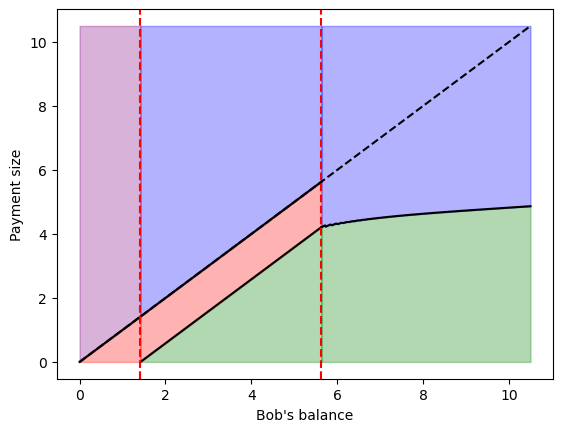

In [39]:
import matplotlib.pyplot as plt

# Bob's optimal strategy
def Optimal_Strategy_Bob(v, k, params: PaymentParams):
    vk = transform_vector_k_times(v, k)
    m = (2 ** k) * params.n
    
    T1, T2, T3, T4 = calculate_threshold_indices(vk, params.C, params.D, params.l_A, params.l_B, m)
    M = int(2 * m * (params.l_A + params.l_B))
    Z = delta_plus(vk, params.C, params.D, params.l_A, params.l_B, m)

    # Different regions of Bob's balance
    x1 = [i / (2 * m) for i in range(T1 + 1)]
    x2 = [i / (2 * m) for i in range(T1 + 1, T2 + 1)]
    x3 = [i / (2 * m) for i in range(T2 + 1, T3)]
    x4 = [i / (2 * m) for i in range(T3, T4)]
    x5 = [i / (2 * m) for i in range(T4, M + 1)]

    plt.xlabel("Bob's balance")
    plt.ylabel('Payment amount')

    v1 = [0] * len(x1)
    v2 = [i / (2 * m) - (T1 + 1) / (2 * m) for i in range(T1 + 1, T2 + 1)]
    v3 = [Z[i] for i in range(T2 + 1, T3)]
    v4 = [i / (2 * m) - (T1 + 1) / (2 * m) for i in range(T3, T4)]
    v5 = [i / (2 * m) - (T1 + 1) / (2 * m) for i in range(T4, M + 1)]
    v6 = [i / (2 * m) - T4 / (2 * m) for i in range(T4, M + 1)]

    w1 = x1
    w2 = x2
    w3 = x3
    w4 = x4
    w5 = x5

    y1 = [params.l_A + params.l_B] * len(x1)
    y2 = [params.l_A + params.l_B] * len(x2)
    y3 = [params.l_A + params.l_B] * len(x3)
    y4 = [params.l_A + params.l_B] * len(x4)
    y5 = [params.l_A + params.l_B] * len(x5)

    plt.plot(x2, v2, marker="", linestyle='-', color='black')
    plt.plot(x3, v3, marker="", linestyle='-', color='black')
    plt.plot(x4, v4, marker="", linestyle='-', color='black')
    plt.plot(x5, v5, marker="", linestyle='-', color='black')
    plt.plot(x5, v6, marker="", linestyle='-', color='black')

    plt.plot(x1, w1, marker="", linestyle='-', color='black')
    plt.plot(x2, w2, marker="", linestyle='-', color='black')
    plt.plot(x4, w4, marker="", linestyle='-', color='black')
    plt.plot(x5, w5, marker="", linestyle='-', color='black')

    # Bob's on-channel and wait region
    plt.fill_between(x2, v2, color='green', alpha=0.3)
    plt.fill_between(x3, v3, color='green', alpha=0.3)
    plt.fill_between(x4, v4, color='green', alpha=0.3)
    plt.fill_between(x5, v6, v5, color='green', alpha=0.3)

    # Bob's on-chain and wait region
    plt.fill_between(x2, w2, y2, color='blue', alpha=0.3)
    plt.fill_between(x3, v3, y3, color='blue', alpha=0.3)
    plt.fill_between(x4, w4, y4, color='blue', alpha=0.3)

    # Bob's on-channel and reset region
    plt.fill_between(x1, v1, w1, color='red', alpha=0.3)
    plt.fill_between(x2, v2, w2, color='red', alpha=0.3)
    plt.fill_between(x4, v4, w4, color='red', alpha=0.3)
    plt.fill_between(x5, v5, w5, color='red', alpha=0.3)
    plt.fill_between(x5, v6, color='red', alpha=0.3)  

    # Bob's on-chain and reset region
    plt.fill_between(x1, w1, y1, color='purple', alpha=0.3)
    plt.fill_between(x5, w5, y5, color='purple', alpha=0.3) 


# Alice's optimal strategy
def Optimal_Strategy_Alice(v, k, params: PaymentParams):
    vk = transform_vector_k_times(v, k)
    m = (2 ** k) * params.n
    
    T1, T2, T3, T4 = calculate_threshold_indices(vk, params.C, params.D, params.l_A, params.l_B, m)
    M = int(2 * m * (params.l_A + params.l_B))
    Z = delta_minus(vk, params.C, params.D, params.l_A, params.l_B, m)

    x5 = [i / (2 * m) for i in range(T1 + 1)]
    x4 = [i / (2 * m) for i in range(T1 + 1, T2 + 1)]
    x3 = [i / (2 * m) for i in range(T2 + 1, T3)]
    x2 = [i / (2 * m) for i in range(T3, T4)]
    x1 = [i / (2 * m) for i in range(T4, M + 1)]

    plt.xlabel("Bob's balance")
    plt.ylabel('Payment amount')
      
    v1 = [0] * len(x1)
    v2 = [-(min(T4, M)/(2 * m) - i / (2 * m)) for i in range(T3, T4)]
    v3 = [Z[i] for i in range(T2 + 1, T3)]
    v4 = [-(min(T4, M)/(2 * m) - i / (2 * m)) for i in range(T1 + 1, T2 + 1)]
    v5 = [-(min(T4, M)/(2 * m) - i / (2 * m)) for i in range(T1 + 1)]
    v6 = [-((T1 + 1) / (2 * m) - i / (2 * m)) for i in range(T1 + 1)]

    w5 = [-(M / (2 * m) - i / (2 * m)) for i in range(T1 + 1)]
    w4 = [-(M / (2 * m) - i / (2 * m)) for i in range(T1 + 1, T2 + 1)]
    w3 = [-(M / (2 * m) - i / (2 * m)) for i in range(T2 + 1, T3)]
    w2 = [-(M / (2 * m) - i / (2 * m)) for i in range(T3, T4)]
    w1 = [-(M / (2 * m) - i / (2 * m)) for i in range(T4, M + 1)]

    y5 = [-(params.l_A + params.l_B)] * len(x5)
    y4 = [-(params.l_A + params.l_B)] * len(x4)
    y3 = [-(params.l_A + params.l_B)] * len(x3)
    y2 = [-(params.l_A + params.l_B)] * len(x2)
    y1 = [-(params.l_A + params.l_B)] * len(x1)

    plt.plot(x2, v2, marker="", linestyle='-', color='black')
    plt.plot(x3, v3, marker="", linestyle='-', color='black')
    plt.plot(x4, v4, marker="", linestyle='-', color='black')
    plt.plot(x5, v5, marker="", linestyle='-', color='black')
    plt.plot(x5, v6, marker="", linestyle='-', color='black')

    plt.plot(x1, w1, marker="", linestyle='-', color='black')
    plt.plot(x2, w2, marker="", linestyle='-', color='black')
    plt.plot(x4, w4, marker="", linestyle='-', color='black')
    plt.plot(x5, w5, marker="", linestyle='-', color='black')

    # Alice's on-channel and wait region
    plt.fill_between(x2, v2, color='green', alpha=0.3)
    plt.fill_between(x3, v3, color='green', alpha=0.3)
    plt.fill_between(x4, v4, color='green', alpha=0.3)
    plt.fill_between(x5, v6, v5, color='green', alpha=0.3)

    # Alice's on-chain and wait region
    plt.fill_between(x2, w2, y2, color='blue', alpha=0.3)
    plt.fill_between(x3, v3, y3, color='blue', alpha=0.3)
    plt.fill_between(x4, w4, y4, color='blue', alpha=0.3)

    # Alice's on-channel and reset region
    plt.fill_between(x1, v1, w1, color='red', alpha=0.3)
    plt.fill_between(x2, v2, w2, color='red', alpha=0.3)
    plt.fill_between(x4, v4, w4, color='red', alpha=0.3)
    plt.fill_between(x5, v5, w5, color='red', alpha=0.3)
    plt.fill_between(x5, v6, color='red', alpha=0.3)  

    # Alice's on-chain and reset region
    plt.fill_between(x1, w1, y1, color='purple', alpha=0.3)
    plt.fill_between(x5, w5, y5, color='purple', alpha=0.3) 


# Optimal policy function
def Optimal_Policy(v, k, params: PaymentParams, unidirectional=False):
    vk = transform_vector_k_times(v, k)
    m = (2 ** k) * params.n
    T1, T2, T3, T4 = calculate_threshold_indices(vk, params.C, params.D, params.l_A, params.l_B, m)

    # Call strategy for Bob
    Optimal_Strategy_Bob(v, k, params)
    if not unidirectional: # If not unidirectional call strategy for Alice 
        Optimal_Strategy_Alice(v, k, params)
 
    if not unidirectional: # If not unidirectional plot the y=0 line
        plt.axhline(0, color='black', linewidth=0.5)

    # Only plot change in regions if it is relevant
    if T1 > 0:
        plt.axvline(x = T1 / (2 * m), color='r', linestyle='--')
    if T2 > 0:
        plt.axvline(x = T2 / (2 * m), color='r', linestyle='--')
    if T3 < len(vk) - 1:
        plt.axvline(x = T3 / (2 * m), color='r', linestyle='--')
    if T4 < len(vk) - 1:
        plt.axvline(x = T4 / (2 * m), color='r', linestyle='--')

    # Plot maximum amount payable on channel for Bob
    x = np.linspace(0, params.l_A + params.l_B, 100)
    plt.plot(x, x, color='black', linestyle='--')
    if not unidirectional: # If not unidirectional plot maximum amount payable on channel for Alice 
        plt.plot(x, -(params.l_A + params.l_B) + x, color='black', linestyle='--')
    
    plt.show()

    
# Example usage of the code
Optimal_Policy(reverse_optimal_cost_vector, 5, params, unidirectional=True)

## Interpretation

If $b \in [0, l_{A,n}^* + l_{B,n}^*]$ is Bob's balance and a payment $\delta \in \mathbb{R}$ is due, then the optimal action is indicated by the colour corresponding to the point $(b,\delta)$ as shown in the following table:

| Colour | Action   |
|--------|----------|
| Green  | $(Cl, W)$ |
| Blue   | $(Cn, W)$ |
| Red    | $(Cl, R)$ |
| Purple | $(Cn, R)$ |